# linear Regression

## theoretical part
first we need to define our linear mode 
$$\hat y= W\cdot X+b$$
we use train set to train our model in order to minimize loss function 
$$loss=MSE(y,\hat y)$$
last we use test set to evaluate our model.
details : https://github.com/Tangjacson/cs189/blob/master/Reading%20note/r2.pdf

## pratical part

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

we set our true model w=[2,-3.4],b=4.2 and noisy is $\sigma=0.01$

In [108]:
true_w=np.array([2,-3.4])
true_b=4.2
n_examples=1000
n_features=2
X=torch.from_numpy(np.random.normal(0,1,(n_examples,n_features)))
Y=X[:,0]*true_w[0]+X[:,1]*true_w[1]+true_b
Y+=torch.from_numpy(np.random.normal(0,.01,size=Y.size()))

In [111]:
X[0],Y[0]

(tensor([-0.4158,  1.1856], dtype=torch.float64),
 tensor(-0.6622, dtype=torch.float64))

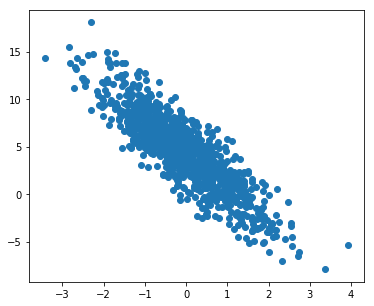

In [34]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,1],Y)

## read data(mini_batch)

In [55]:
def data_iter(batch_size,X,Y):
    n_examples=len(X)
    index=list(range(n_examples))
    random.shuffle(index)
    for i in range(0,n_examples,batch_size):
        j=torch.LongTensor(index[i:min(i+batch_size,n_examples)])#transform index
                                                         #to LongTensor
        yield X.index_select(0,j),Y.index_select(0,j)

**index_select()** object:

In [46]:
import random
a=torch.tensor([4,5,6,7])
index=torch.tensor([2,3])
a.index_select(0,index)

tensor([6, 7])

## initiate parameter

In [75]:
w=torch.tensor(np.random.normal(0,1,(n_features,1)),requires_grad=True,dtype=torch.float64)
b=torch.tensor(1.,requires_grad=True,dtype=torch.float64)

## def model

In [70]:
def model(X,w,b):
    return torch.mm(X,w)+b

def loss(Y,Y_hat):
    return (Y_hat-Y.view(Y_hat.size()))**2/2

def SGD(params,lr,batch_size):
    for param in params:
        param.data-=lr*param.grad/batch_size# prevent destroy the grad or there
                                            # will be an -1 accumulate to grad

## train model

In [88]:
lr=0.3
n_epochs=3

for epoch in range(n_epochs):
    for x,y in data_iter(10,X,Y):
        y_hat=model(x,w,b)
        l=loss(y,y_hat).sum()
        l.backward()
        SGD([w,b],lr,10)
        
        #reset after backward each time
        w.grad.data.zero_()
        b.grad.data.zero_()
    
    train_loss=loss(model(X,w,b),Y)
    print("epoch %d,loss:%f"%(epoch+1,train_loss.mean()))

epoch 1,loss:0.000055
epoch 2,loss:0.000049
epoch 3,loss:0.000048


## Implement in a more pytorch way

In [116]:
import torch.utils.data as Data
batch_size = 10
dataset = Data.TensorDataset(X,Y)# concate the X,Y
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)#splist X,Y

In [117]:
from torch import nn
class linearRegression(nn.Module):
    def __init__(self,n_features):
        super(linearRegression,self).__init__()
        self.linear=nn.Linear(n_features,1)
    
    def forward(self,x):
        Y=self.linear(x)
        return Y
    
lR=linearRegression(n_features)
print(lR)

linearRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [118]:
net=nn.Sequential(
    nn.Linear(n_features,1)#input and outcome dim of each example
)

In [119]:
from torch.nn import init
init.normal_(net[0].weight,mean=0,std=.01)
init.constant_(net[0].bias,val=0)#directly net[0].bias.data.fill_(0)

Parameter containing:
tensor([0.], requires_grad=True)

In [136]:
loss=nn.MSELoss()

import torch.optim as optim

optimizer=optim.SGD(net.parameters(),lr=.003)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [137]:
for epoch in range(n_epochs):
    for x,y in data_iter:
        output=net(x.float())
        l=loss(output,y.float().view(-1,1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch%d,loss:%f'%(epoch,l))

epoch0,loss:0.000089
epoch1,loss:0.000166
epoch2,loss:0.000056
